# MWS Secondary Target Selection

## MWS_SPECIAL_HYADES_VERYBRIGHT_SV

Maintainers:
  - Boris Gaensicke (selection/catalog)
  - Andrew Cooper (secondary target code)

In [1]:
ls -l ../raw

total 1
lrwxrwxrwx 1 apcooper apcooper 89 Aug 29 20:27 desi_sv_hyades.fits -> /project/projectdirs/desi/external/mws/sv/MWS_SPECIAL_HYADES_SV/1/raw/desi_sv_hyades.fits


In [2]:
pwd

'/global/projecta/projectdirs/desi/external/mws/sv/MWS_SPECIAL_HYADES_VERYBRIGHT_SV/1/code'

Stars in the Hyades; selected all stars in Gaia with parallax distance < 100pc in a 15x15 deg box centred on the cluster.

The selection criteria are:

???

In [3]:
pwd

'/global/projecta/projectdirs/desi/external/mws/sv/MWS_SPECIAL_HYADES_VERYBRIGHT_SV/1/code'

In [4]:
import os
import numpy as np
from astropy.table import Table, Column
import astropy.coordinates as coord
import astropy.units as u
import astropy.io.fits as fits

In [5]:
target_class    = 'MWS_SPECIAL_HYADES_VERYBRIGHT_SV'
input_filename  = 'desi_sv_hyades.fits'

REF_CAT   = 'G'
REF_EPOCH = '2015.5'

In [6]:
# Relative paths
input_path  = os.path.join('..','raw',input_filename)

# Separate bright and faint output
output_path = os.path.join('..','indata','{}.fits'.format(target_class))

output_dir  = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    print('Making output directory: {}'.format(os.path.abspath(output_dir)))
    os.makedirs(dir)

In [7]:
import astropy.table as table
d = table.Table.read(input_path)
d[0:3]

ra,ra_error,dec,dec_error,source_id,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,duplicated_source,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_g_mean_mag_error,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_bp_mean_mag_error,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,phot_rp_mean_mag_error,bp_rp,radial_velocity,radial_velocity_error,teff_val,a_g_val,e_bp_min_rp_val,radius_val,lum_val
deg,mas,deg,mas,,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,e-/s,e-/s,mag,mag,e-/s,e-/s,mag,mag,e-/s,e-/s,mag,mag,mag,km / s,km / s,K,mag,mag,solRad,solLum
float64,float64,float64,float64,int64,float64,float32,float64,float32,float64,float32,uint8,float32,float32,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float64,float64,float32,float64,float32,float32,float32,float64
59.2256812428,0.067684196615,12.2388731852,0.0390140253599,38289878259378688,12.1593154438,0.076325,56.1410907116,0.137403,8.3598747581,0.089992,1,10733.7,4.95035,15.611493,0.000500738623776,1975.12,10.8327,17.112406,0.00595482575039,13777.6,19.4045,14.413987,0.00152915981863,2.6984186,nan,nan,3809.38,0.0483,0.027,nan,nan
59.2456272243,0.06408678366,12.2690942142,0.0386253296406,38291080850217088,10.0872576312,0.0715764,21.5822102954,0.137371,-114.547529231,0.0926993,0,16145.5,8.30504,15.168234,0.000558487470691,3080.79,12.9731,16.629734,0.00457198533527,20422.4,24.5983,13.986655,0.00130774445254,2.6430788,nan,nan,4055.095,0.1353,0.1063,nan,nan
59.1425624591,0.0378283411337,12.37183076,0.0241876797598,38295753774630784,15.969817101,0.0423035,39.9452841041,0.0800702,-40.2411806576,0.0604176,0,104315.0,56.0913,13.142495,0.000583810183627,26759.2,63.6188,14.282707,0.00258129180225,117142.0,133.497,12.090142,0.00123732439818,2.192565,24.3523150218,0.958902,4010.9402,0.0447,0.028,nan,nan


In [8]:
print(d.colnames)

['ra', 'ra_error', 'dec', 'dec_error', 'source_id', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'duplicated_source', 'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_mag', 'phot_g_mean_mag_error', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_bp_mean_mag', 'phot_bp_mean_mag_error', 'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'phot_rp_mean_mag', 'phot_rp_mean_mag_error', 'bp_rp', 'radial_velocity', 'radial_velocity_error', 'teff_val', 'a_g_val', 'e_bp_min_rp_val', 'radius_val', 'lum_val']


In [9]:
BRIGHT_TIME_BRIGHT_LIMIT = 16.0

finite_mag                 = np.isfinite(d['phot_g_mean_mag'])
brighter_than_bright_limit = (d['phot_g_mean_mag'] < BRIGHT_TIME_BRIGHT_LIMIT) & finite_mag
fainter_than_bright_limit  = (d['phot_g_mean_mag'] > BRIGHT_TIME_BRIGHT_LIMIT) & finite_mag

print('Undefined mags for {:d} targets'.format((~finite_mag).sum()))
print('Mag range: {:5.2f} < G < {:5.2f}'.format(d['phot_g_mean_mag'][finite_mag].min() ,d['phot_g_mean_mag'][finite_mag].max()))
print('Targets brighter than G = 16: {}/{} ({:3.2%})'.format(brighter_than_bright_limit.sum(),
                                                             len(d),
                                                             brighter_than_bright_limit.sum()/len(d)))

verybright_time_targets = brighter_than_bright_limit

Undefined mags for 0 targets
Mag range:  3.16 < G < 20.99
Targets brighter than G = 16: 1538/2523 (60.96%)


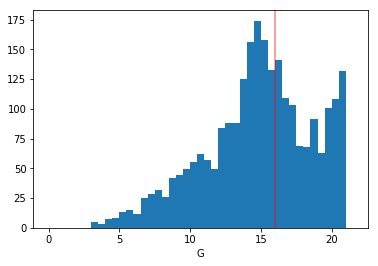

In [15]:
import matplotlib.pyplot as pl
pl.hist(d['phot_g_mean_mag'][finite_mag],bins=np.arange(0,22,0.5));
pl.xlabel('G');
pl.axvline(BRIGHT_TIME_BRIGHT_LIMIT,c='r',alpha=0.5);

Adjust to secondary target data model:

In [11]:
output = d['ra','dec','pmra','pmdec','source_id'][verybright_time_targets]

for cn_old,cn_new in zip(['ra','dec','source_id','pmra','pmdec'],['RA','DEC','REF_ID','PMRA','PMDEC']):
    output.rename_column(cn_old,cn_new) 

output.add_column(Column(np.repeat(False,len(output)),'OVERRIDE'))
#output.add_column(Column(np.zeros(len(output),dtype=np.float32),'PMRA'))
#output.add_column(Column(np.zeros(len(output),dtype=np.float32),'PMDEC'))
output.add_column(Column(np.repeat(REF_CAT,len(output)),'REF_CAT'))
output.add_column(Column(np.repeat(REF_EPOCH,len(output)),'REF_EPOCH'))

Add header:

In [12]:
output.meta['VRAWDATA'] = int(os.path.abspath(input_path).split(os.path.sep)[-3])
print(output.meta['VRAWDATA'])

1


In [13]:
output[0:3]

RA,DEC,PMRA,PMDEC,REF_ID,OVERRIDE,REF_CAT,REF_EPOCH
deg,deg,mas / yr,mas / yr,,,,
float64,float64,float64,float64,int64,bool,str1,str6
59.2256812428,12.2388731852,56.1410907116,8.3598747581,38289878259378688,False,G,2015.5
59.2456272243,12.2690942142,21.5822102954,-114.547529231,38291080850217088,False,G,2015.5
59.1425624591,12.37183076,39.9452841041,-40.2411806576,38295753774630784,False,G,2015.5


Write output:

In [14]:
print('Writing {:d} rows of output to {}'.format(len(output),os.path.abspath(output_path)))
output.write(output_path,overwrite=True)

Writing 1538 rows of output to /global/projecta/projectdirs/desi/external/mws/sv/MWS_SPECIAL_HYADES_VERYBRIGHT_SV/1/indata/MWS_SPECIAL_HYADES_VERYBRIGHT_SV.fits
